## GDrive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#Import Libraries
import os, glob, cv2
import numpy as np 
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

## EDA

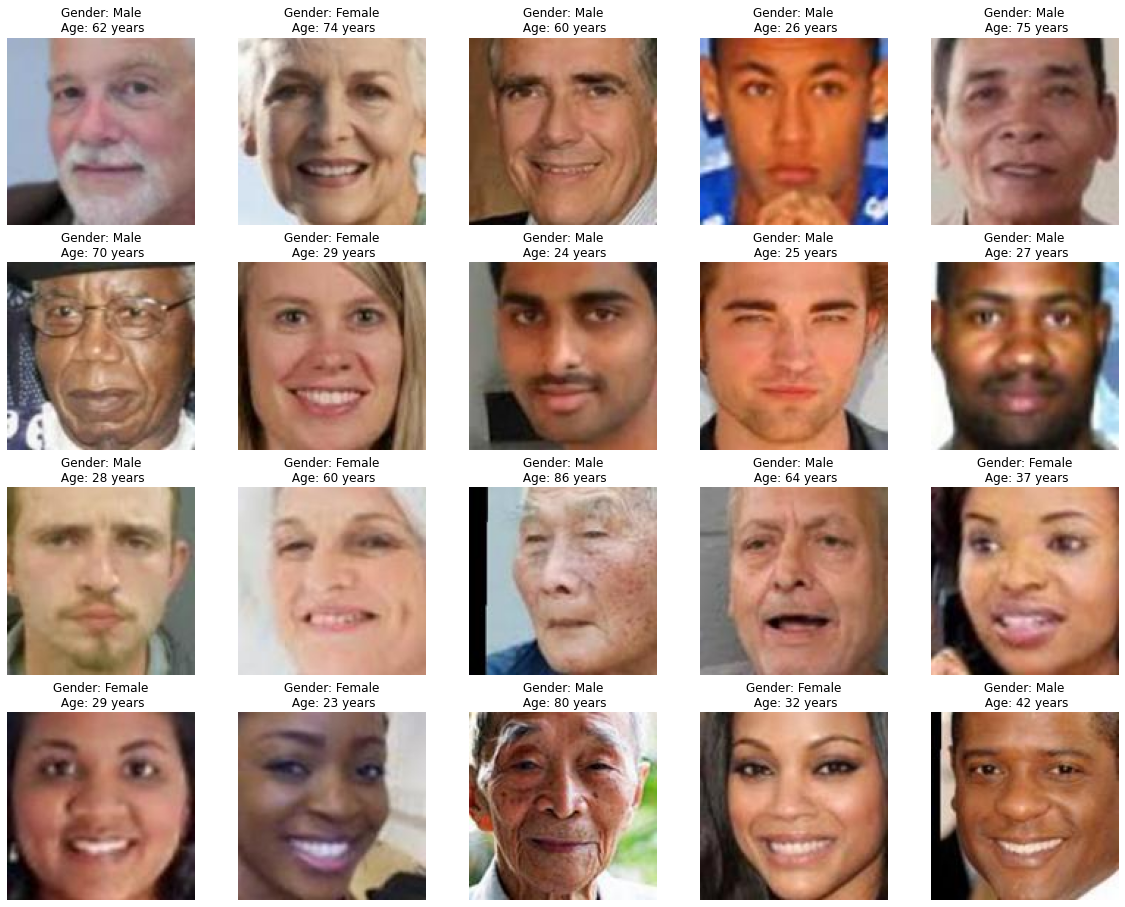

In [ ]:
#Function to read the dataset
def fetch_data(dataset_path, ext='jpg'):
  #Storing names of the images in the dataset
  def file_info(path):
    fname = os.path.split(path)[1]
    fname = os.path.splitext(fname)[0]
    #Get the age, gender and race info from file name
    age, gender, race,_ = fname.split('_')
    return int(age), dataset_dict['gender_id'][int(gender)]
  #Read the jpg files
  files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
  rec_temp = []
  #Iterate through each file
  for file in files:
      info = file_info(file)
      rec_temp.append(info)
  #Create dataframe of the file names      
  df = pd.DataFrame(rec_temp)
  df['file'] = files
  df.columns = ['age', 'gender', 'file']
  return df
#Dataset path
data_path = '/content/gdrive/MyDrive/train_val/'
#Storing the categorical to numerical key
dataset_dict = {'gender_id': {0: 'male', 1: 'female'}}
#Number of genders considered
Genders=['Male','Female']
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
#Using the function to get the dataset file names in dataframe
df = fetch_data(data_path)

#Image size
IM_HEIGHT = 128
IM_WIDTH =  128

#Function for reading the images from the filenames
def fetch_image(fname):
  #Get the file name
  imdir=fname
  #Read the image
  img=cv2.imread(imdir)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #Resize the image to shape
  img = cv2.resize(img,(IM_HEIGHT,IM_WIDTH))
  return img

#Function to display the images
def display_images(df):
  #Number of images to display
  imgs_to_display = 20
  #Get random images from the dataset
  samples = df.sample(imgs_to_display) 
  #Create an empty figure
  plt.figure(figsize=(20,20))
  #Iterate through the selected images
  for i in range(len(samples.index)):
    #Create subplot
    plt.subplot(5,5,i+1)
    plt.axis('off')
    #Read image
    img = fetch_image(np.array(samples['file'])[i])
    plt.imshow(img)
    #Fetch the gender and age info     
    title = "Gender: "
    gender = Genders[np.array(samples['gender'].map({'male':0, 'female':1}))[i]]
    title = title + gender
    age = np.array(samples['age'])[i]
    title = title + "\n Age: " + str(age) + " years"
    #Create the title        
    plt.title(title)
#Use the function to display the images
display_images(df)

##Data pre-processing

In [ ]:
#Splitting ratio of the dataset between training and validation set
Data_Split_Ratio = 0.8

#Creating user defined class for data generation
class Dataset_Generator():
  #Constructor
  def __init__(self, df):
      self.df = df
  #Function for creating random training and validation image indicies     
  def image_inds(self):
    #Get random permutations
    perm = np.random.permutation(len(self.df))
    #Length of the training set
    len_train = int(len(self.df) * Data_Split_Ratio)
    inds_train = perm[:len_train]
    #Length of the validation set
    inds_test = perm[len_train:]       
    # id conversion
    self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
    self.max_age = self.df['age'].max() 
    #Return the indicies      
    return inds_train, inds_test

  #Function for preprocessing the images
  def img_process(self, image_path):
    #Read and resize the image
    img = Image.open(image_path)
    img = img.resize((IM_HEIGHT, IM_WIDTH))
    #Image normalization
    img = np.array(img) / 255.0     
    return img

  #Storing images in numpy arrays    
  def generate_images(self, img_ind, is_training, batch_size=16):      
    # lists for image, gender and age data
    images, genders, ages = [], [], []
    #Loop over the data
    while True:
      for ind in img_ind:
        #Fetch image, age and gender data
        image = self.df.iloc[ind]           
        person_age = image['age']
        person_gender = image['gender_id']
        image_file = image['file']
        #Use preprocessing function    
        img = self.img_process(image_file)
        #Store the results into the arrays
        ages.append(person_age / self.max_age)
        genders.append(to_categorical(person_gender, len(dataset_dict['gender_id'])))
        images.append(img)              
        # yielding condition
        if len(images) >= batch_size:
          yield np.array(images), [np.array(ages), np.array(genders)]
          images, ages, genders = [], [], []

#Instantiate the data class                
generator_data = Dataset_Generator(df)
#Use the data class for getting the train and validation indicies
train_idx, valid_idx = generator_data.image_inds()

## Custom CNN

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                          

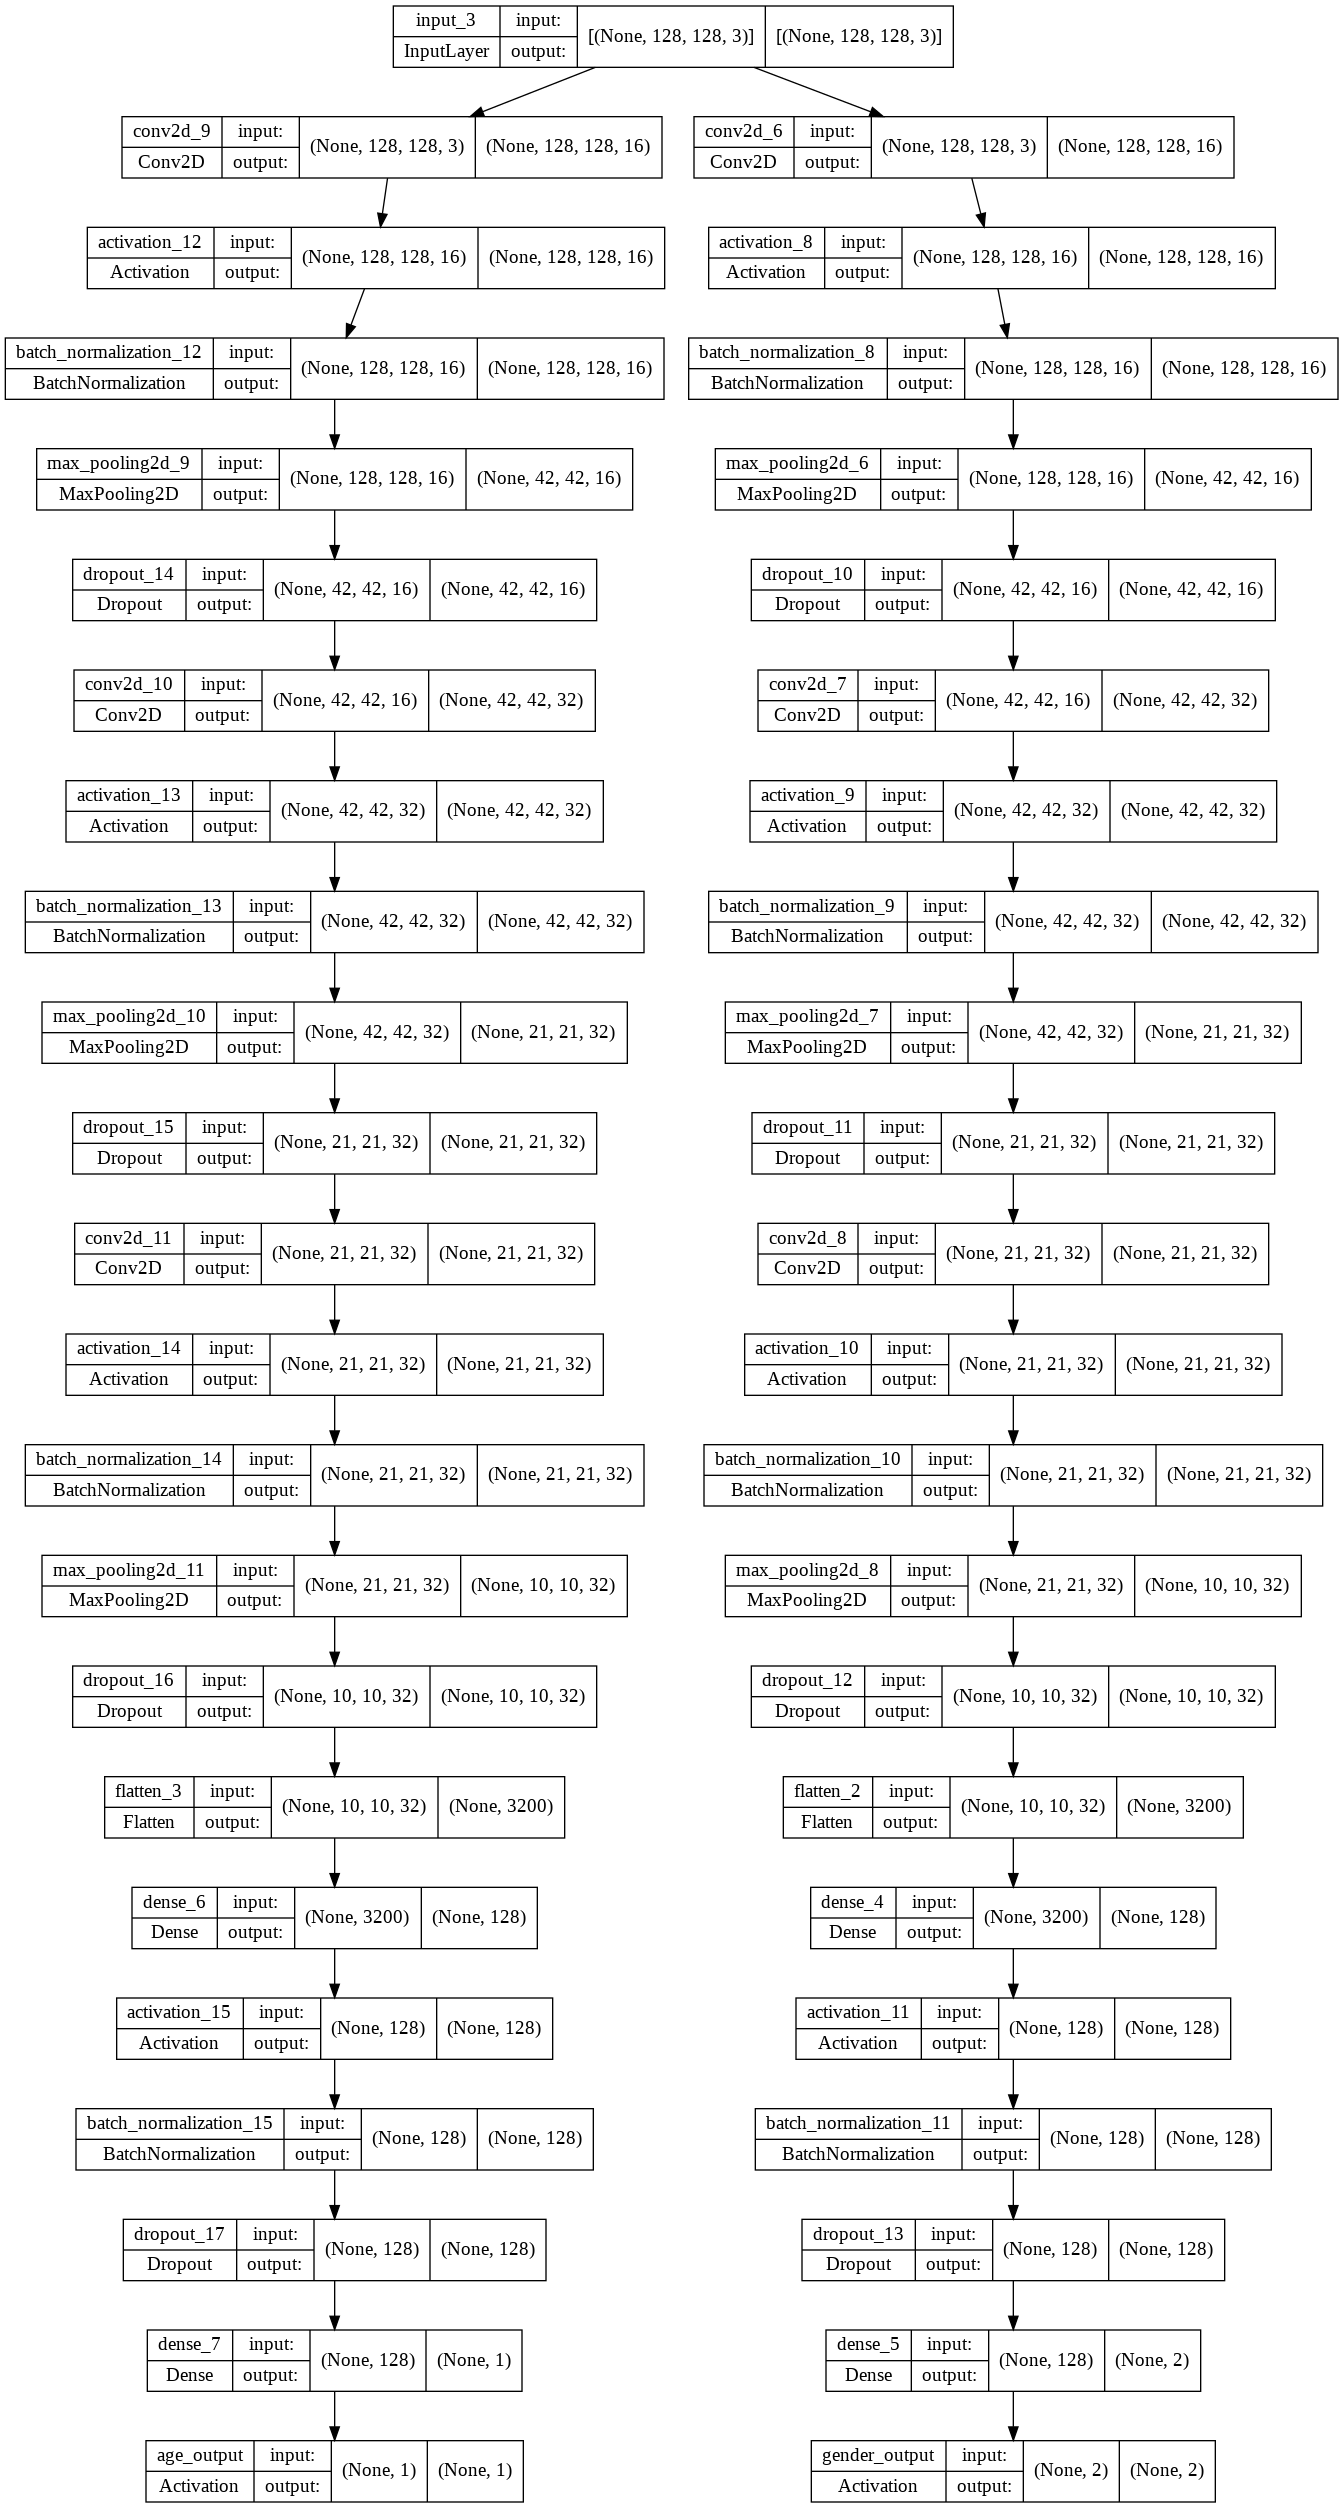

In [ ]:
#Import the required packages
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, Dense, Flatten, Input, BatchNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam

#Size of the convolution filters
filter_size = (3,3)
#Activation function used
activation_func = "relu"

#Model class
class Scratch_Model():
  #Function for the feature extraction part of the model
  def feature_extractor(self, inputs):
    #Construction the model using the function API
    #Model Input Layer
    f = Conv2D(16, filter_size, padding="same")(inputs)
    f = Activation(activation_func)(f)
    f = BatchNormalization(axis=-1)(f)
    f = MaxPooling2D(pool_size=filter_size)(f)
    #Using dropout for overfitting
    f = Dropout(0.25)(f)
    #Model 2nd layer
    f = Conv2D(32, filter_size, padding="same")(f)
    f = Activation(activation_func)(f)
    f = BatchNormalization(axis=-1)(f)
    f = MaxPooling2D(pool_size=(2, 2))(f)
    f = Dropout(0.25)(f)
    #3rd layer
    f = Conv2D(32, filter_size, padding="same")(f)
    f = Activation(activation_func)(f)
    f = BatchNormalization(axis=-1)(f)
    f = MaxPooling2D(pool_size=(2, 2))(f)
    f = Dropout(0.25)(f)
    return f
  #Function for the age prediction output branch
  def age_branch(self, inputs):
    #Call the feature extraction function   
    f = self.feature_extractor(inputs)
    #Flattening the output of the feature extractor
    f = Flatten()(f)
    #Fully connected layer
    f = Dense(128)(f)
    f = Activation("relu")(f)
    f = BatchNormalization()(f)
    f = Dropout(0.5)(f)
    #Output of the branch
    f = Dense(1)(f)
    f = Activation("linear", name="age_output")(f)
    return f
  #Function for the gender prediction branch
  def gender_branch(self, inputs, num_genders=2):
    #Calling the feature extractor
    f = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
    f = self.feature_extractor(inputs)
    #Flattening
    f = Flatten()(f)
    #Fully connected layer
    f = Dense(128)(f)
    f = Activation("relu")(f)
    f = BatchNormalization()(f)
    f = Dropout(0.5)(f)
    #Output of the branch
    f = Dense(num_genders)(f)
    f = Activation("sigmoid", name="gender_output")(f)
    return f
  #Function for assembling of the final model
  def overall_model(self, w, h):
    #Input shape of the model (equal to the image shape)
    input_shape = (h, w, 3)
    #Creating inputs
    inputs = Input(shape=input_shape)
    #Calling the gender and age branch
    gender_branch = self.gender_branch(inputs)
    age_branch = self.age_branch(inputs)
    #Creating the final model using the functional API
    final_model = Model(inputs=inputs,
                  outputs = [age_branch, gender_branch],
                  name="face_net")
    return final_model

#Instantiating the model class for creating the model   
modelA = Scratch_Model().overall_model(IM_HEIGHT,IM_WIDTH)

#Model summary and plot
modelA.summary()
from keras.utils.vis_utils import plot_model
plot_model(modelA, show_shapes=True)

## Compile and Train the Model 


In [ ]:
#Learning rate of the optimizer
lr = 1e-4
init_lr = 1e-4
#Number of epochs to train the model
epochs = 50
#Size of the batches
batch_size = 32
#Optimizer for the model
optmz = Adam(learning_rate=lr, decay=init_lr / epochs)
#Model compilation
modelA.compile(optimizer=optmz, 
              loss={
                  'age_output': 'mse',  
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy'})

#Creating the training and validation dataset
train_set = generator_data.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_set = generator_data.generate_images(valid_idx, is_training=True, batch_size=batch_size)
#Model training
history = modelA.fit(train_set,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    validation_data=valid_set,
                    validation_steps=len(valid_idx)//batch_size)

#Saving the model
modelA.save("age_gender_A.h5")

Epoch 1/50
125/125 [==============================] - 14s 101ms/step - loss: 14.4251 - age_output_loss: 3.5854 - gender_output_loss: 0.8340 - age_output_mae: 1.4800 - gender_output_accuracy: 0.6355 - val_loss: 0.5792 - val_age_output_loss: 0.1273 - val_gender_output_loss: 0.6992 - val_age_output_mae: 0.3014 - val_gender_output_accuracy: 0.6925
Epoch 2/50
125/125 [==============================] - 12s 98ms/step - loss: 11.1268 - age_output_loss: 2.7643 - gender_output_loss: 0.6946 - age_output_mae: 1.2984 - gender_output_accuracy: 0.7005 - val_loss: 1.3062 - val_age_output_loss: 0.3060 - val_gender_output_loss: 0.8213 - val_age_output_mae: 0.4442 - val_gender_output_accuracy: 0.5454
Epoch 3/50
125/125 [==============================] - 12s 99ms/step - loss: 9.0129 - age_output_loss: 2.2376 - gender_output_loss: 0.6254 - age_output_mae: 1.1650 - gender_output_accuracy: 0.7385 - val_loss: 3.5405 - val_age_output_loss: 0.8668 - val_gender_output_loss: 0.7338 - val_age_output_mae: 0.7646 - 

## Learning Curves


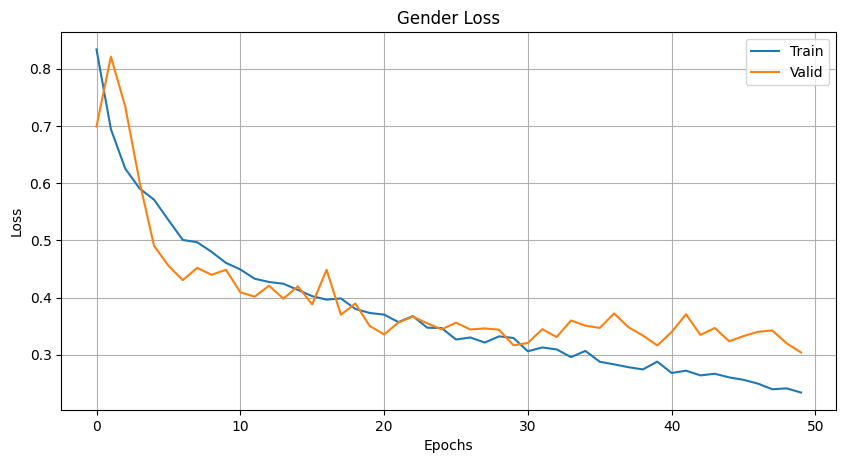

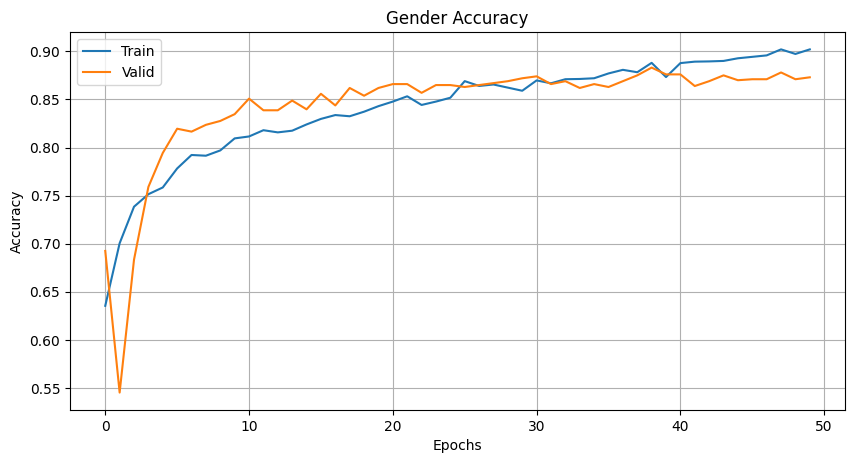

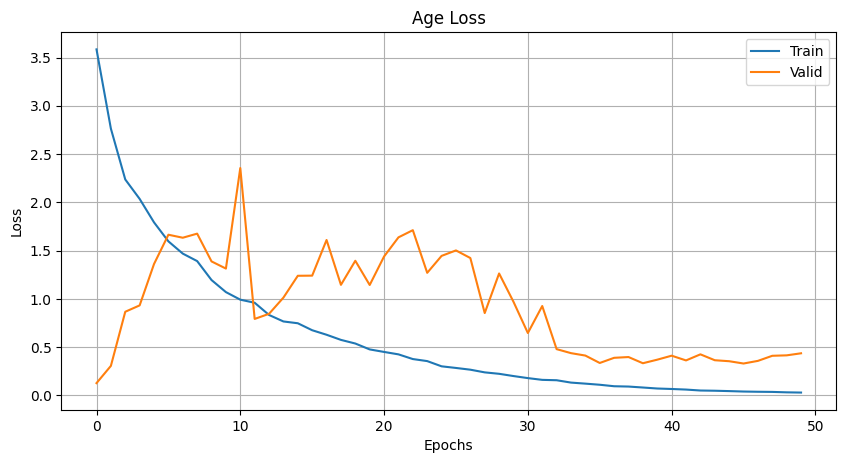

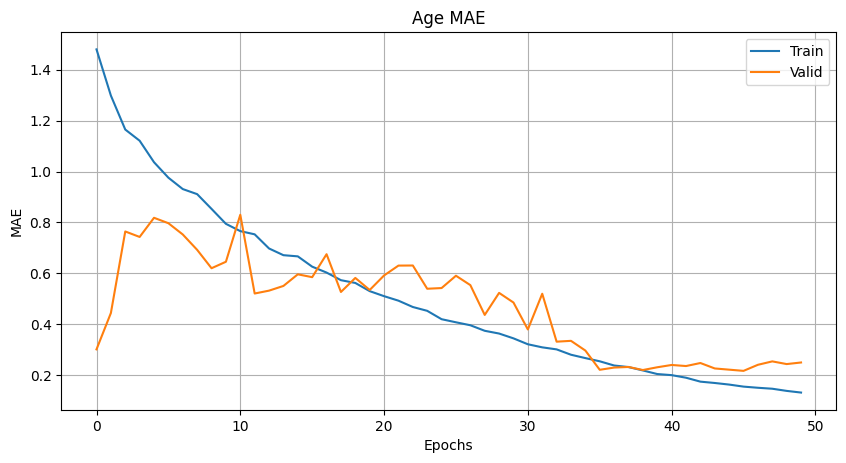

In [ ]:
#Plotting Gender Loss
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),history.history['gender_output_loss']);
plt.plot(range(epochs),history.history['val_gender_output_loss']);
plt.grid()
#Plot title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gender Loss')
plt.legend(['Train', 'Valid'])

#Plotting Gender Accuracy
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),history.history['gender_output_accuracy']);
plt.plot(range(epochs),history.history['val_gender_output_accuracy']);
plt.grid()
#Title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Gender Accuracy')
plt.legend(['Train', 'Valid'])

#Plotting Age Loss
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),history.history['age_output_loss']);
plt.plot(range(epochs),history.history['val_age_output_loss']);
plt.grid()
#Labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Age Loss')
plt.legend(['Train', 'Valid'])

#Plotting Age MAE
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),history.history['age_output_mae']);
plt.plot(range(epochs),history.history['val_age_output_mae']);
plt.grid()
#Title
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Age MAE')
plt.legend(['Train', 'Valid'])


## Pre-trained VGG


58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                             

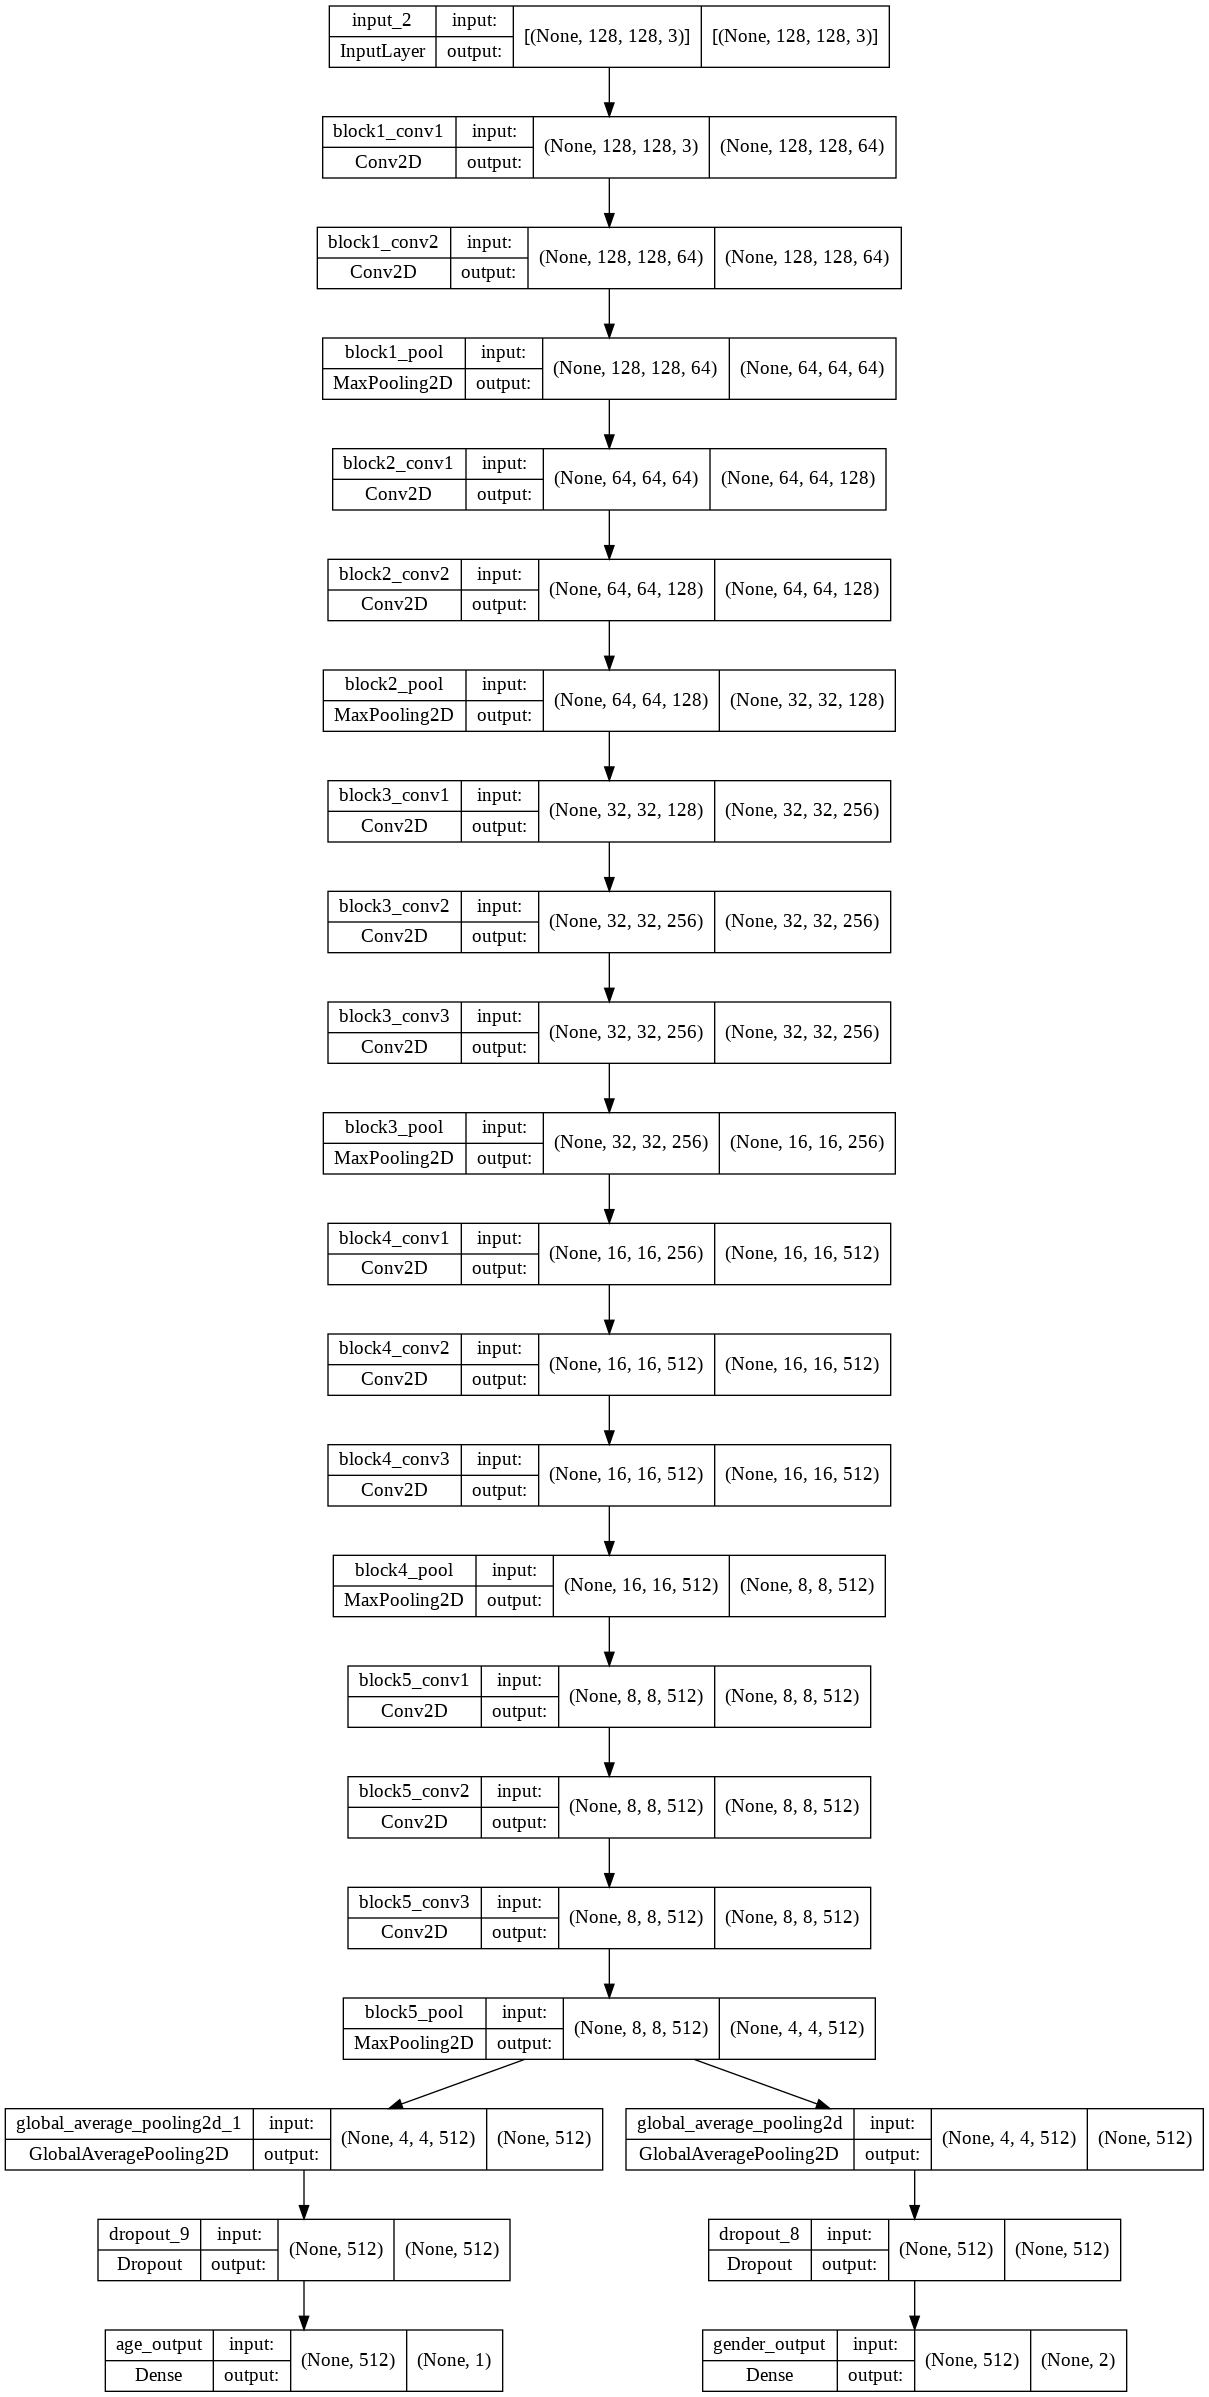

In [ ]:
# Load VGG16 net feature extractor without the top layer
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IM_HEIGHT,IM_WIDTH,3))
base_model.trainable=False
# Add the top 2 output layers
#Gender Output
gender_x = base_model.output
gender_x = GlobalAveragePooling2D()(gender_x)
gender_x = Dropout(0.5)(gender_x)
gender_output = Dense(2, activation='sigmoid',name='gender_output')(gender_x)
#Age Output
age_x = base_model.output
age_x = GlobalAveragePooling2D()(age_x)
age_x = Dropout(0.5)(age_x)
age_output = Dense(1, activation='linear', name='age_output')(age_x)

# Create the final model
modelB = Model(inputs=base_model.inputs, outputs=[age_output, gender_output])

modelB.summary()
from keras.utils.vis_utils import plot_model
plot_model(modelB, show_shapes=True)

## Compile and Train


In [ ]:
#Model Compilation
modelB.compile(optimizer=optmz, 
              loss={
                  'age_output': 'mse',  
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy'})

#Model Training
history = modelB.fit(train_set,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    validation_data=valid_set,
                    validation_steps=len(valid_idx)//batch_size)

modelB.save("age_gender_B.h5")

Epoch 1/50
125/125 [==============================] - 15s 97ms/step - loss: 2.2159 - age_output_loss: 0.5359 - gender_output_loss: 0.7219 - age_output_mae: 0.5975 - gender_output_accuracy: 0.5247 - val_loss: 0.2000 - val_age_output_loss: 0.0331 - val_gender_output_loss: 0.6744 - val_age_output_mae: 0.1432 - val_gender_output_accuracy: 0.6250
Epoch 2/50
125/125 [==============================] - 12s 96ms/step - loss: 1.0155 - age_output_loss: 0.2367 - gender_output_loss: 0.6888 - age_output_mae: 0.3933 - gender_output_accuracy: 0.5832 - val_loss: 0.1803 - val_age_output_loss: 0.0286 - val_gender_output_loss: 0.6600 - val_age_output_mae: 0.1337 - val_gender_output_accuracy: 0.6724
Epoch 3/50
125/125 [==============================] - 12s 96ms/step - loss: 0.7106 - age_output_loss: 0.1609 - gender_output_loss: 0.6713 - age_output_mae: 0.3199 - gender_output_accuracy: 0.6145 - val_loss: 0.1656 - val_age_output_loss: 0.0251 - val_gender_output_loss: 0.6505 - val_age_output_mae: 0.1246 - val

## Learning Curve

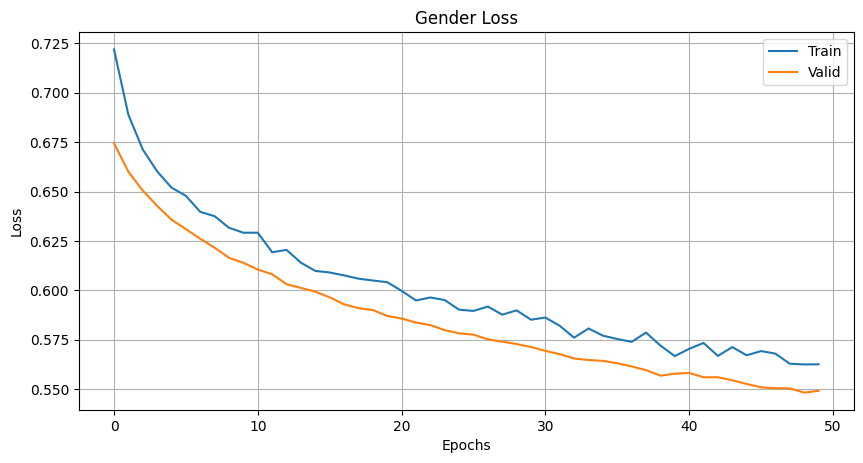

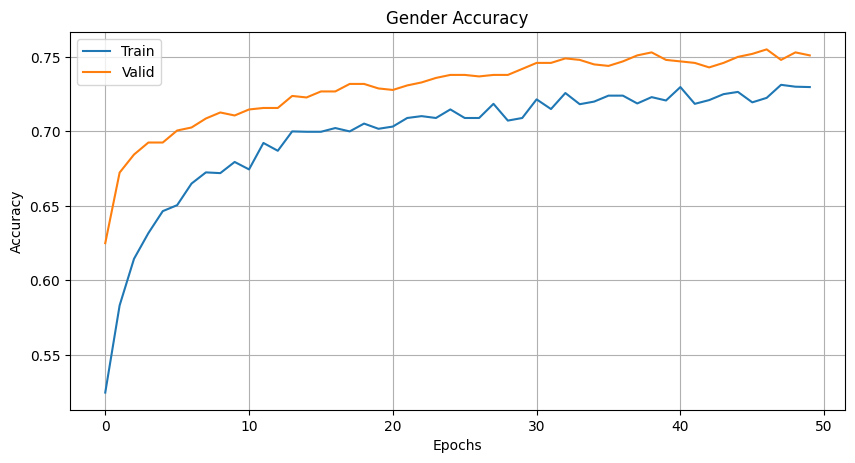

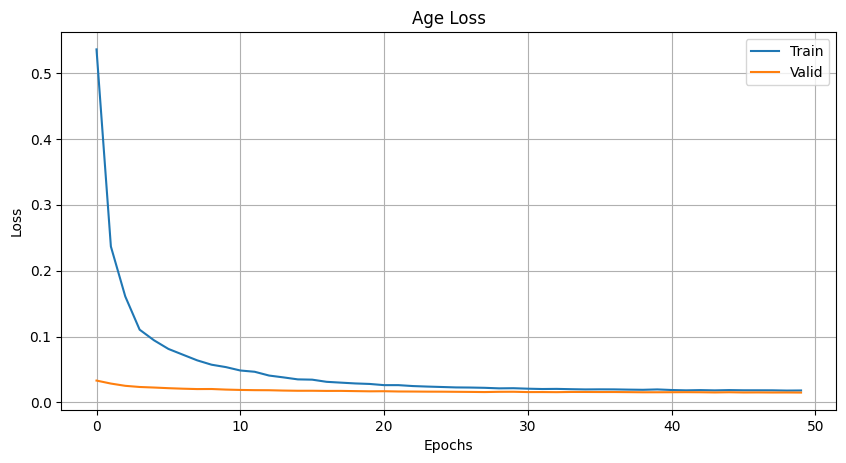

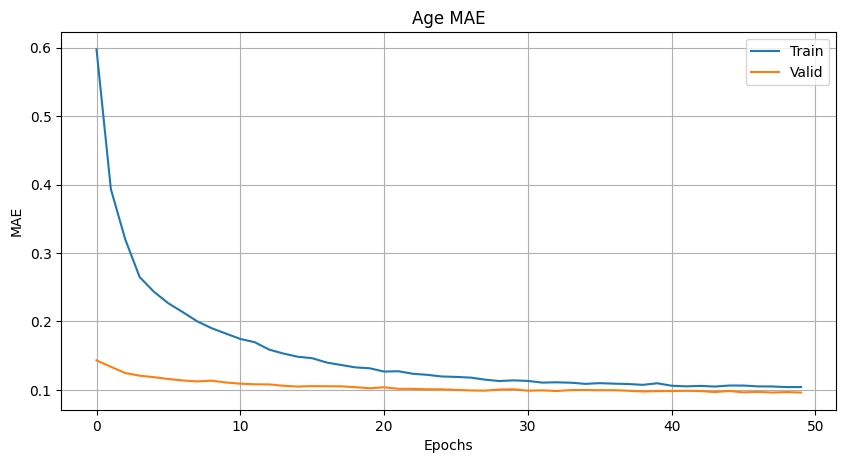

In [ ]:
#Plotting Gender Loss
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),history.history['gender_output_loss']);
plt.plot(range(epochs),history.history['val_gender_output_loss']);
plt.grid()
#Plot title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gender Loss')
plt.legend(['Train', 'Valid'])

#Plotting Gender Accuracy
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),history.history['gender_output_accuracy']);
plt.plot(range(epochs),history.history['val_gender_output_accuracy']);
plt.grid()
#Title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Gender Accuracy')
plt.legend(['Train', 'Valid'])

#Plotting Age Loss
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),history.history['age_output_loss']);
plt.plot(range(epochs),history.history['val_age_output_loss']);
plt.grid()
#Labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Age Loss')
plt.legend(['Train', 'Valid'])

#Plotting Age MAE
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),history.history['age_output_mae']);
plt.plot(range(epochs),history.history['val_age_output_mae']);
plt.grid()
#Title
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Age MAE')
plt.legend(['Train', 'Valid'])
